# Udacity Self-Driving Car Nanodegree
## Advanced Lane Finding Project
The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
### Import all modules
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle as pickle
import glob as glob
from moviepy.editor import VideoFileClip
from src import line as Line

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
### Apply a distortion correction to raw images.
### Apply a perspective transform to rectify binary image ("birds-eye view").

These first functions will calibrate the camera and provide distortion coefficients for the `undistort_image( )` and `unwarp_image( )` functions, as well as several later ones.

In [37]:
### Calibrate Camera and Undistort Image ###
def calibrate_camera( plot='yes' ):
    
    # Determine chessboard corners on 6 x 9 chessboard 
    nx = 9
    ny = 6

    # Initialize object point structures
    initial_obj_pts = np.zeros( ( ny * nx, 3 ), np.float32 )
    initial_obj_pts[:,:2] = np.mgrid[ 0:nx, 0:ny ].T.reshape( -1, 2 )
    obj_pts = [ ]
    img_pts = [ ]

    # Glob list of all images
    cal_images = glob.glob( './camera_cal/calibration*.jpg' )
    test_image = cv2.imread( './camera_cal/calibration1.jpg' )
    road_image = cv2.imread( './test_images/test1.jpg' )
    image_size = ( test_image.shape[1], test_image.shape[0] )

    # Figure prep
    if plot == 'yes' or plot == 'YES':
        plt.figure( figsize=( 15, 20 ) ) 
        plt.figtext( 0.5, 0.9, 'Detected Corners', fontsize=20, ha='center')

    for index, file_name in enumerate( cal_images ):

        # Read image, convert to grayscale
        img = cv2.imread( file_name )
        gray = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY ) 

        # Find any chessboard corners
        found, corners = cv2.findChessboardCorners( gray, (nx, ny), None )

        # If found, add object and image points
        if found == True:
            obj_pts.append( initial_obj_pts )
            img_pts.append( corners )

            # Plot the found image
            if plot == 'yes' or plot == 'YES':
                plt.subplot( 8, 4, len( img_pts ) )
                cv2.drawChessboardCorners( img, (nx, ny), corners, found )
                plt.imshow( img )
                plt.title( file_name )
                plt.axis( 'off' )
                
                plt.savefig( "./output_images/chessboard_img.jpg" )
 
    # Calibrate camera given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( obj_pts, img_pts, image_size, None, None )
    
    if plot == 'yes' or plot == 'YES':
        print( 'Corners were detected on', str( len(img_pts) ), 'of', str( len(cal_images) ), 'images.' )
        print( 'Success rate:', str( len(img_pts) * 100.0 / len(cal_images) ), '% of calibration images' )
        plt.show( )
        
        print( "using camera_cal/calibration1.jpg and test_images/test1.jpg." )
        plt.figure( figsize=( 15, 10 ) )
        plt.figtext( 0.5, 0.9, 'Undistorted Example Images', fontsize=20, ha='center')
        
        plt.subplot( 2, 2, 1 )
        plt.imshow( test_image )
        plt.title( "Original Chessboard Image" )
        plt.axis( 'off' )
        
        plt.subplot( 2, 2, 2 ) 
        plt.imshow( cv2.undistort( test_image, mtx, dist, None, mtx ) )
        plt.title( "Undistorted Chessboard Image" )
        plt.axis( 'off' )
        
        plt.subplot( 2, 2, 3 )
        plt.imshow( cv2.cvtColor( road_image, cv2.COLOR_BGR2RGB ) )
        plt.title( "Original On-Road Image" )
        plt.axis( 'off' )
        
        plt.subplot( 2, 2, 4 )
        plt.imshow( cv2.cvtColor( cv2.undistort( road_image, mtx, dist, None, mtx ), cv2.COLOR_BGR2RGB ) )
        plt.title( "Undistorted On-Road Image" )
        plt.axis( 'off' )
        
        plt.savefig( "./output_images/undist_img.jpg" )
        
    return ret, mtx, dist
        

def undistort_image( img, mtx, dist, plot='yes' ):
    
    # Undistort calibrated camera image given object, image points.
    undistorted_img = cv2.undistort( img, mtx, dist, None, mtx )

    if plot == 'yes' or plot == 'YES':
        plt.figure( figsize=( 15, 5 ) )
        plt.figtext( 0.5, 0.9, 'Undistorted Example Images', fontsize=20, ha='center')

        plt.subplot( 1, 2, 1 )
        plt.imshow( cv2.cvtColor( img, cv2.COLOR_BGR2RGB ) )
        plt.title( "Original On-Road Image" )
        plt.axis( 'off' )

        plt.subplot( 1, 2, 2 )
        plt.imshow( cv2.cvtColor( undistorted_img, cv2.COLOR_BGR2RGB ) )
        plt.title( "Undistorted On-Road Image" )
        plt.axis( 'off' )
    
    return undistorted_img


def unwarp_image( img, plot='yes' ):
    
    # Define image height and width
    h, w = img.shape[:2]
    
    # Define source and destination points for transform
    src = np.float32([ ( 575, 464), ( 707, 464 ), ( 258, 682 ), ( 1049, 682 ) ] )
    dst = np.float32([ ( 450, 0), ( w - 450, 0 ), ( 450, h ), ( w - 450, h ) ] )
    
    # Get the transform matrix, M, and the inverse, Minv [ cv2.getPerspectiveTransform( ) ]
    M = cv2.getPerspectiveTransform( src, dst )
    Minv = cv2.getPerspectiveTransform( dst, src )
    
    # Warp image to a top-down view [ cv2.warpPerspective( ) ]
    warped_img = cv2.warpPerspective( img, M, ( w, h ), flags=cv2.INTER_LINEAR )
    
    if plot == 'yes' or plot == 'YES':
        
        # Plot unwarped image
        f, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=(20,10) )
        f.subplots_adjust( hspace = .2, wspace=.05 )
        ax1.imshow( img )
        x = [ src[0][0], src[2][0], src[3][0], src[1][0], src[0][0] ]
        y = [ src[0][1], src[2][1], src[3][1], src[1][1], src[0][1] ]
        ax1.plot( x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2 )
        ax1.set_ylim( [ h, 0 ] )
        ax1.set_xlim( [ 0, w ] )
        ax1.set_title( 'Undistorted Image', fontsize=30 )
        ax2.imshow( warped_img )
        ax2.set_title( 'Unwarped Image', fontsize=30 )
        
        plt.savefig( "./output_images/unwarped_img.jpg" )
    
    return warped_img, M, Minv

###

### Use color transforms, gradients, etc., to create a thresholded binary image.

The different thresholding functions are shown in a form similar to those used in the lecture notes.  The `pipeline( )` function is defined showing use of only the `hls_s_select( )` and `hls_l_select( )` thresholding for the final pipeline result.  Thresholds of `[ 110, 255 ]` and `[ 230, 255 ]` are used respectively.

In [40]:
### Sobel Gradient Absolute Thresholding ###

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh( img, orient='x', thresh_min=0, thresh_max=255 ):
    # Apply the following steps to img
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x' or orient == 'X':
        sobel = cv2.Sobel( gray, cv2.CV_64F, 1, 0 )
    elif orient == 'y' or orient == 'Y':
        sobel = cv2.Sobel( gray, cv2.CV_64F, 0, 1 )
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute( sobel )
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8( 255 * abs_sobel / np.max( abs_sobel ) )
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    bin_output = np.zeros_like( scaled_sobel )
    bin_output[ ( scaled_sobel >= thresh_min ) & ( scaled_sobel <= thresh_max ) ] = 1
    
    # 6) Return this mask as your binary_output image

    return bin_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_sobel_thresh( img, sobel_kernel=3, mag_thresh=( 0, 255 ) ):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )

    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel( gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel )
    sobel_y = cv2.Sobel( gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel )
    
    # 3) Calculate the magnitude 
    gradient_mag = np.sqrt( sobel_x**2 + sobel_y**2 )
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad_mag_scaled = ( gradient_mag / ( np.max( gradient_mag ) / 255 ) ).astype( np.uint8 ) 
    
    # 5) Create a binary mask where mag thresholds are met
    bin_output = np.zeros_like( grad_mag_scaled )
    bin_output[ ( grad_mag_scaled >= mag_thresh[0] ) & ( grad_mag_scaled <= mag_thresh[1] ) ] = 1
    
    # 6) Return this mask as your binary_output image
    return bin_output


# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold( img, sobel_kernel=3, thresh=( 0, np.pi/2 ) ):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute( cv2.Sobel( gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel ) )
    abs_sobel_y = np.absolute( cv2.Sobel( gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel ) )
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2( abs_sobel_y, abs_sobel_x )
    
    # 5) Create a binary mask where direction thresholds are met
    bin_output = np.zeros_like( direction )
    bin_output[ ( direction >= thresh[0] ) & ( direction <= thresh[1] ) ] = 1

    # 6) Return this mask as your binary_output image
    return bin_output


# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_s_select( img, thresh=( 0, 255 ) ):
    
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor( img, cv2.COLOR_RGB2HLS )
    
    S = hls_img[ :, :, 2 ]
    
    # 2) Apply a threshold to the S channel
    bin_output = np.zeros_like( S )
    bin_output[ ( S > thresh[0] ) & ( S <= thresh[1] ) ] = 1
    
    # 3) Return a binary image of threshold result
    return bin_output


# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_l_select( img, thresh=( 200, 255 ) ):
    
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor( img, cv2.COLOR_RGB2HLS )
    
    L = hls_img[ :, :, 1 ]
    
    # 2) Apply a threshold to the S channel
    bin_output = np.zeros_like( L )
    bin_output[ ( L > thresh[0] ) & ( L <= thresh[1] ) ] = 1
    
    # 3) Return a binary image of threshold result
    return bin_output


# Define an image-processing pipeline
def pipeline( img, mtx, dist, plot='yes' ):
    
    image = undistort_image( img, mtx, dist, 'no' )
    
    if plot != 'yes' and plot != 'YES':
        
        image, M, Minv = unwarp_image( image, 'no' )
    
    else:
        
        abs_x_binary = abs_sobel_thresh( image, orient='x', thresh_min=20, thresh_max=100 )

        abs_y_binary = abs_sobel_thresh( image, orient='y', thresh_min=20, thresh_max=100 )

        mag_binary = mag_sobel_thresh( image, sobel_kernel=3, mag_thresh=(30, 100) )

        dir_binary = dir_threshold( image, sobel_kernel=15, thresh=(0.9, 1.1) )
### TUNE FURTHER
    hls_s_binary = hls_s_select( image, thresh=(110, 255) )
    
    hls_l_binary = hls_l_select( image, thresh=(230, 255) )
  
    # Combine the binary thresholds, Comment in/out thresholds you choose to use
    combined_binary = np.zeros_like( hls_s_binary )
    
    combined_binary[ \
                    ( hls_s_binary == 1 ) \
                    | ( hls_l_binary == 1 ) \
    #                | ( dir_binary == 1 ) \
    #                | ( mag_binary == 1 ) \
    #                | ( dir_binary == 1 ) \
    #                | ( abs_x_binary == 1 ) \
    #                | ( abs_y_binary == 1 ) \
                   ] = 1
    
    if plot == 'yes' or plot == 'YES':
        
        # Plot the result
        f, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 24, 9 ) )
        f.tight_layout( )
        ax1.imshow( image )
        ax1.set_title( 'Original Image', fontsize=40 )
        ax2.imshow( abs_x_binary, cmap='gray' )
        ax2.set_title( 'Abs Thresholded Gradient', fontsize=40 )
        plt.subplots_adjust( left=0., right=1, top=0.9, bottom=0. )
        plt.savefig( "./output_images/pipeline1.jpg" )
        
        f, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 24, 9 ) )
        f.tight_layout( )
        ax1.imshow( mag_binary, cmap='gray' )
        ax1.set_title( 'Mag Thresholded Gradient', fontsize=40 )
        ax2.imshow( dir_binary, cmap='gray' )
        ax2.set_title( 'Dir Thresholded Gradient', fontsize=40 )
        plt.subplots_adjust( left=0., right=1, top=0.9, bottom=0. )
        plt.savefig( "./output_images/pipeline2.jpg" )
        
        f, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 24, 9 ) )
        f.tight_layout( )
        ax1.imshow( hls_s_binary, cmap='gray' )
        ax1.set_title( 'Thresholded S', fontsize=40 )
        ax2.imshow( hls_l_binary, cmap='gray' )
        ax2.set_title( 'Thresholded L', fontsize=40 )
        plt.subplots_adjust( left=0., right=1, top=0.9, bottom=0. )
        plt.savefig( "./output_images/pipeline3.jpg" )
        
        f, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 24, 9 ) )
        f.tight_layout( )
        ax1.imshow( img, cmap='gray' )
        ax1.set_title( 'Original Image', fontsize=40 )
        ax2.imshow( combined_binary, cmap='gray' )
        ax2.set_title( 'Pipeline Result', fontsize=40 )
        plt.subplots_adjust( left=0., right=1, top=0.9, bottom=0. )
        plt.savefig( "./output_images/pipeline4.jpg" )
    
        return combined_binary, None
    
    else: 
        
        return combined_binary, Minv


# Test pipeline against all test images
def test_transformed_pipeline( images ):
    
    # Set up plot
    print("Filtered Lane Lines against Test Images")
    figure, axes = plt.subplots( len( images ), 2, figsize=( 10, 20 ) )
    figure.subplots_adjust( hspace = .2, wspace=.001 )
    axes = axes.ravel( )

    index = 0

    # Iterate through all test images
    for image in images:

        img = cv2.imread( image )
        img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB )

        img_bin, Minv = pipeline( img, mtx, dist, 'no' )

        axes[ index ].imshow( img )
        axes[ index ].axis( 'off' )
        index += 1
        axes[ index ].imshow( img_bin, cmap='gray' )
        axes[ index ].axis( 'off' )
        index += 1
    
###

Corners were detected on 17 of 20 images.
Success rate: 85.0 % of calibration images


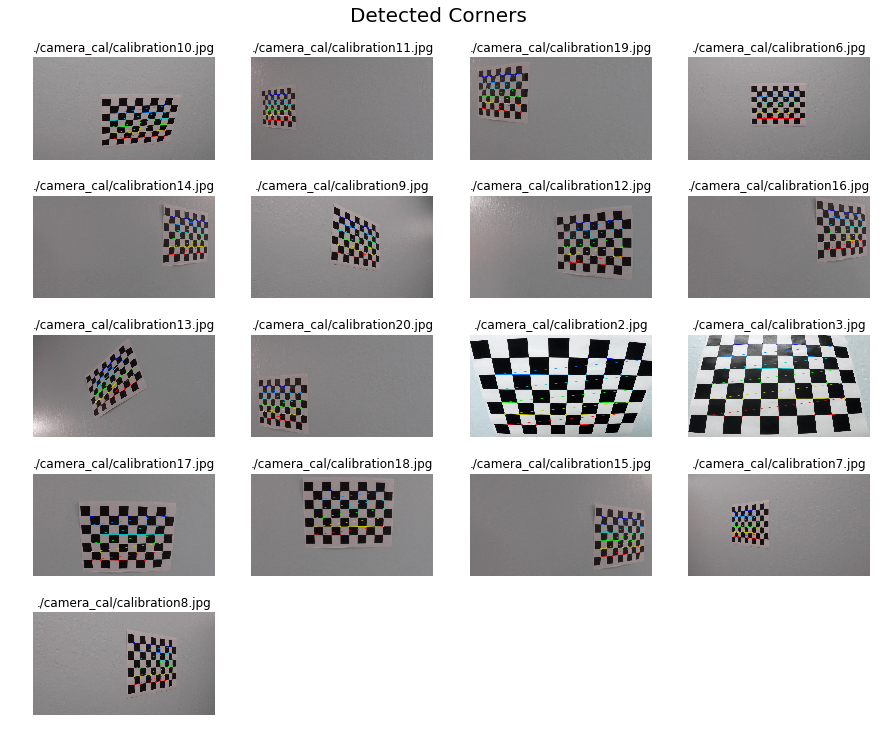

using camera_cal/calibration1.jpg and test_images/test1.jpg.


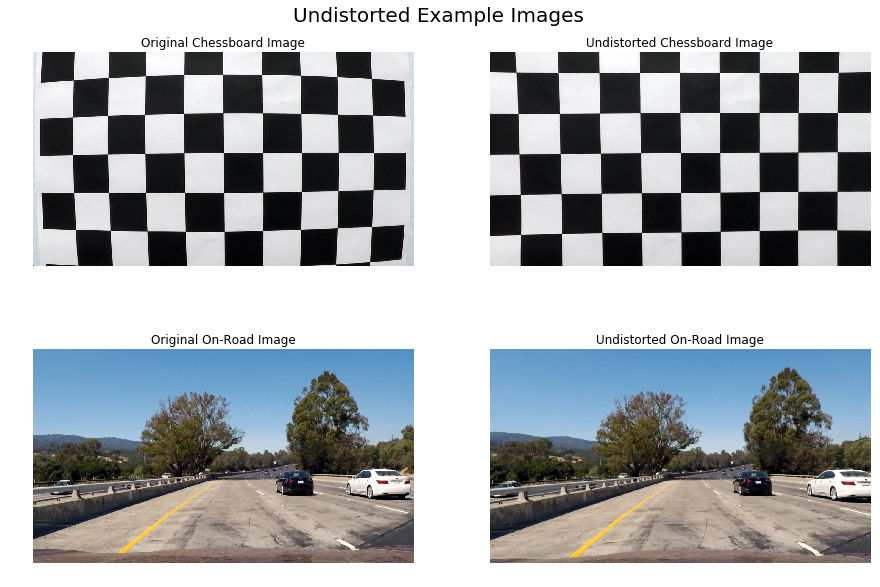

In [41]:
### Calibrate Camera

ret, mtx, dist = calibrate_camera( 'yes' )

###

The below functions provide the first visual tests of the `pipeline( )` function.  All thresholds are plotted alongside the original image as well as the final pipeline result.  Thresholds shown include:
* Sobel Absolute 
* Sobel Magnitude
* Sobel Direction
* HLS S-Channel
* HLS L-Channel

Below those eight images are another test of the transformed and thresholded images shown alongside their unedited counterparts.  

Filtered Lane Lines against Test Images


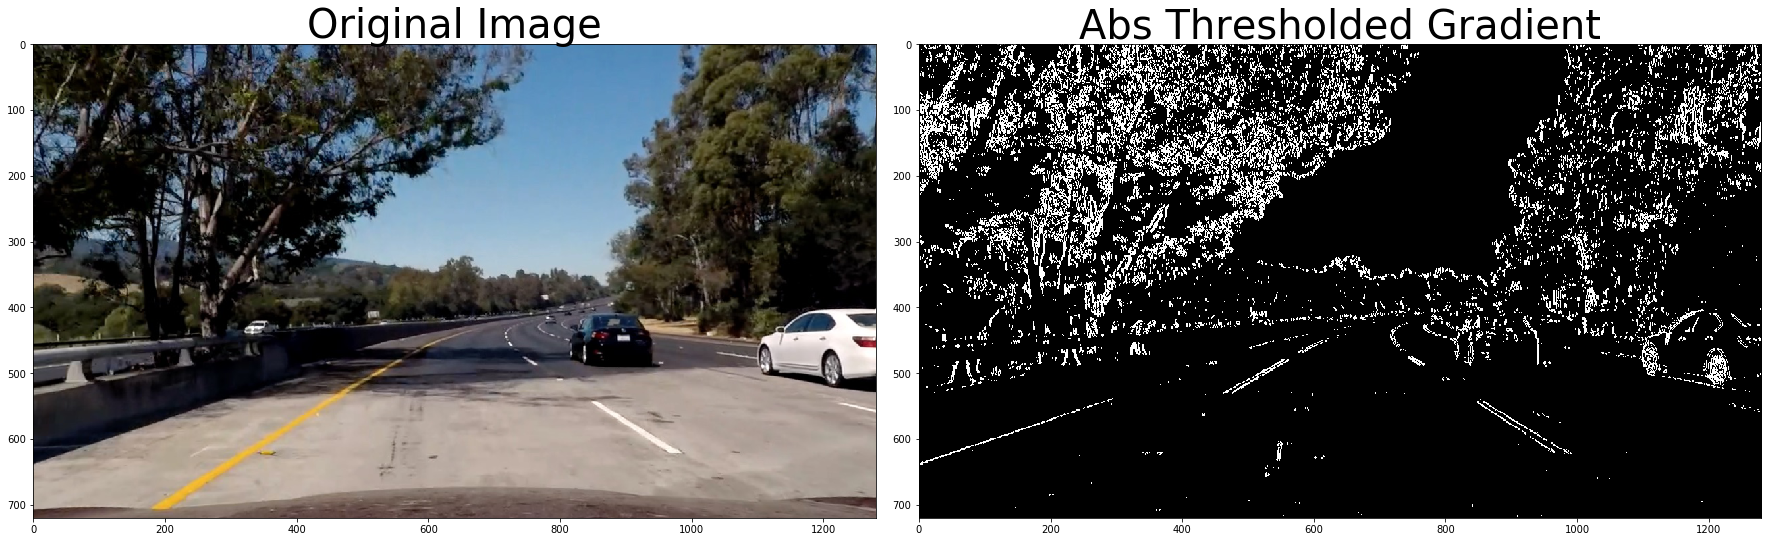

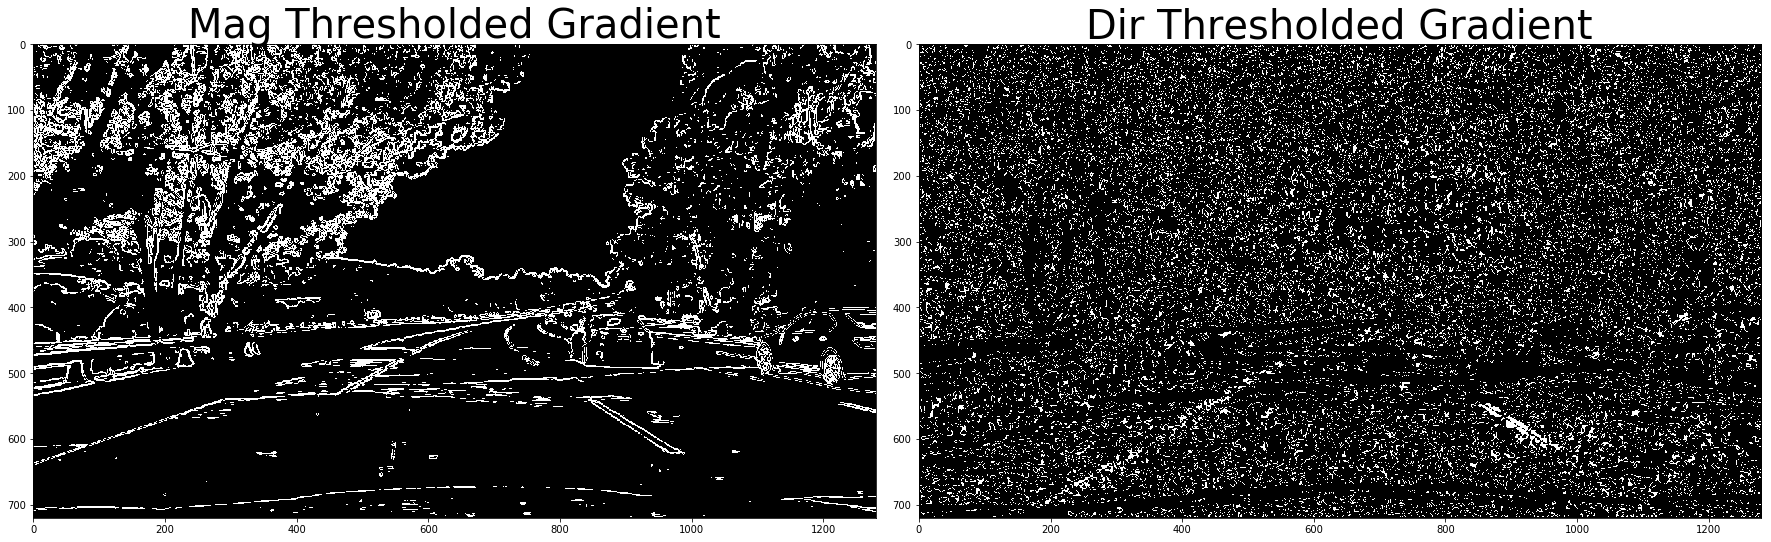

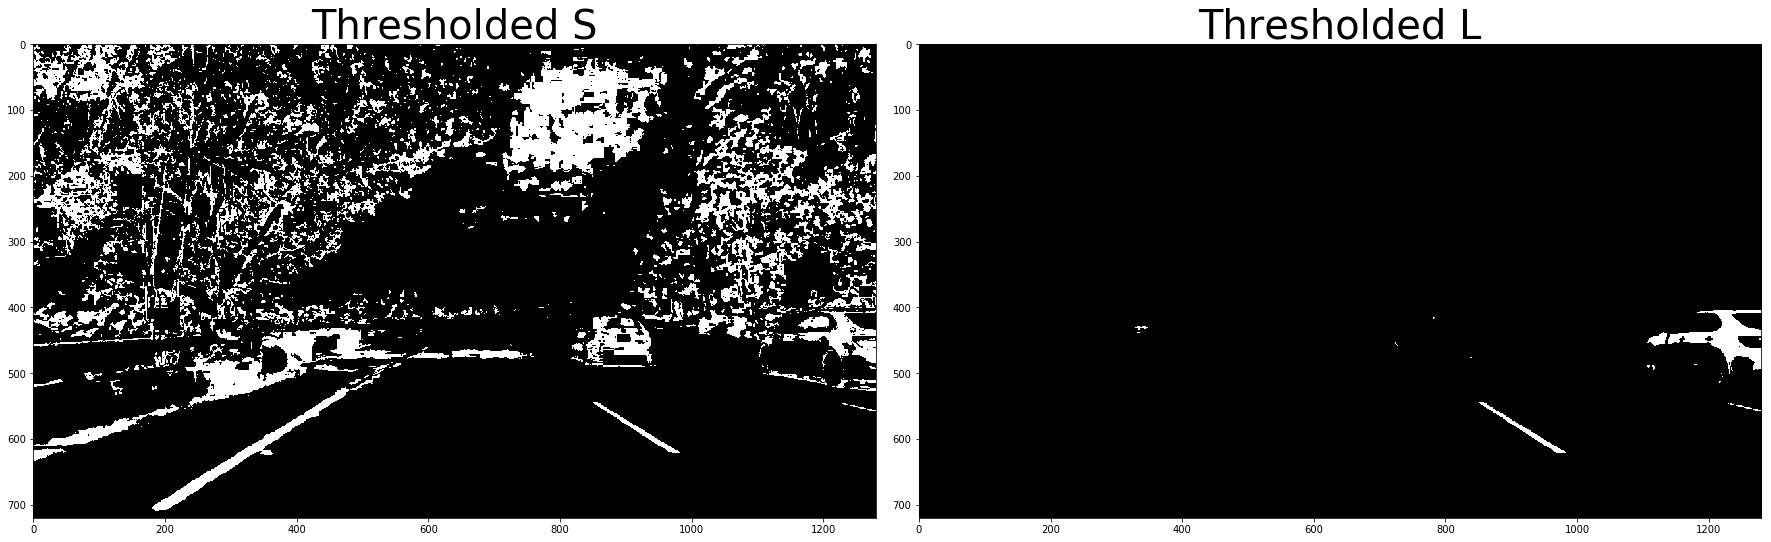

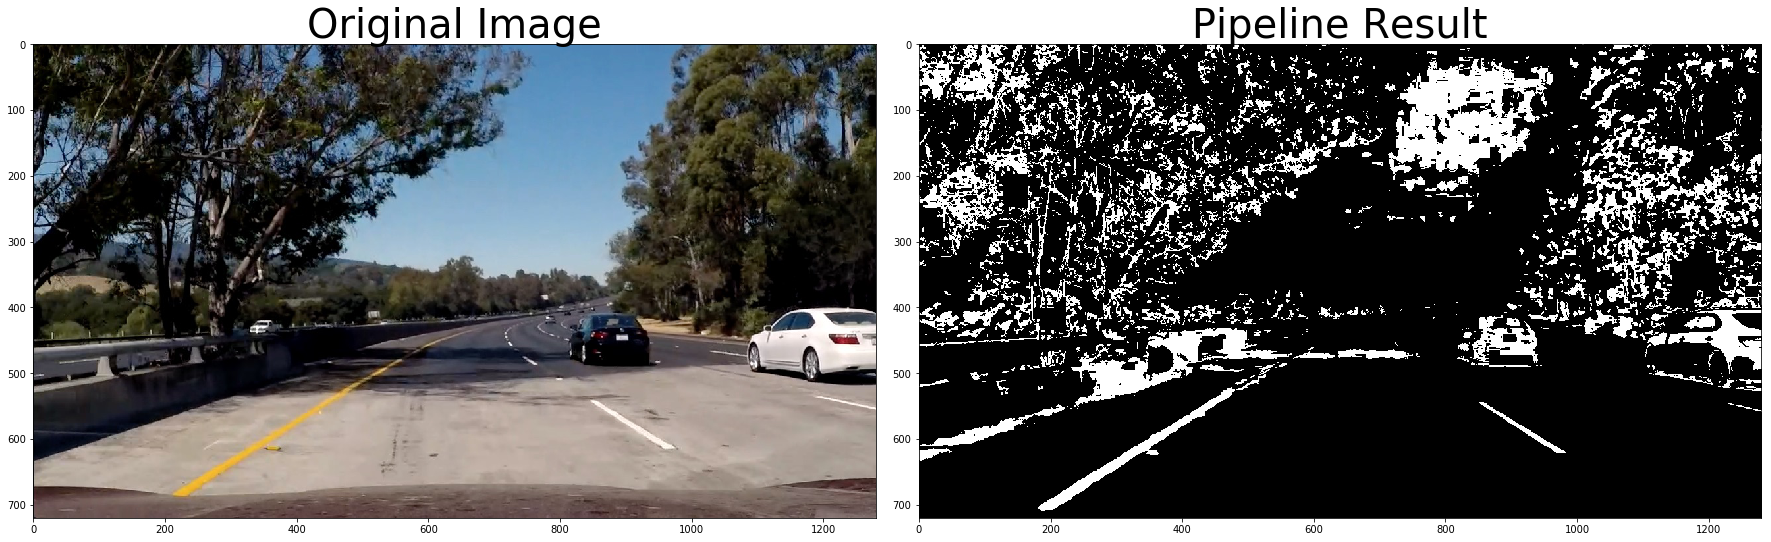

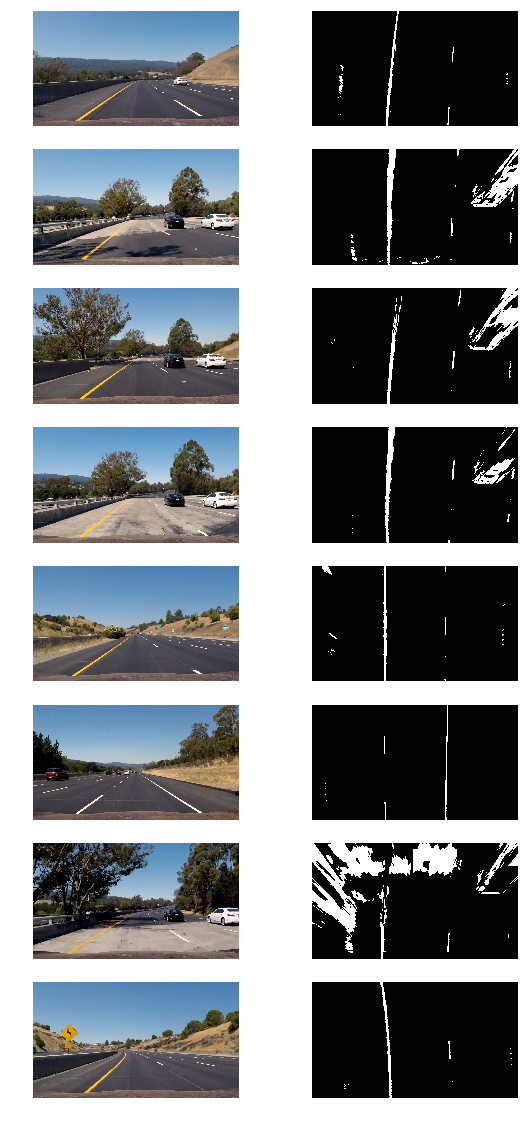

In [42]:
### Test Pipeline

# Read in an image 
image1 = mpimg.imread( './test_images/test5.jpg' )

# Make a list of example images
images = glob.glob( './test_images/*.jpg' )

# Run the function
image_piped_1, Minv = pipeline( image1, mtx, dist, 'yes' )

# View test images transformed and processed
test_transformed_pipeline( images )

### 

### Detect lane pixels and fit to find the lane boundary.

The below functions detect and plot sliding windows over estimations of where the lane markers are detected.  Histogram data is provided to error check the lane marker estimations.

In [25]:
### Fit and plot sliding fitted windows

# Method to fit polynomial as sliding window to binary image with lines extracted
def fit_sliding_window( img ):

    # Set number of windows, window height, margin width, and min pixels to recenter window
    nwindows = 10
    win_height, margin, minpix = np.int( img.shape[0] / nwindows ), 80, 40
    
    # Identify x, y positions of all nonzero pixels in the image
    nzero = img.nonzero( )
    nzeroy, nzerox = np.array( nzero[0] ), np.array( nzero[1] )
    
    # Histogram of the lower half of the image
    histogram = np.sum( img[img.shape[0]//2:, :], axis=0 )
    
    # Current positions to be updated for each window
    mid = np.int( histogram.shape[0] // 2 )
    quarter = np.int( mid // 2 )  
    cur_l = np.argmax( histogram[ quarter:mid ] ) + quarter
    cur_r = np.argmax( histogram[ mid:( mid + quarter ) ] ) + mid
    
    # Create empty lists to receive left, right lane pixel indices and visualization data 
    lane_inds_l, lane_inds_r, rect_data = [ ], [ ], [ ]

    # Step through each window
    for window in range( nwindows ):
        
        # Identify window boundaries in x and y, right and left
        x_l_l = cur_l - margin
        x_h_l = cur_l + margin
        
        x_l_r = cur_r - margin
        x_h_r = cur_r + margin
        
        y_l = img.shape[0] - ( window + 1 ) * win_height
        y_h = img.shape[0] - window * win_height
        
        rect_data.append( ( y_l, y_h, x_l_l, x_h_l, x_l_r, x_h_r ) )
        
        # Identify nonzero pixels in x, y within window
        good_inds_l = ((nzeroy >= y_l) & (nzeroy < y_h) & (nzerox >= x_l_l) & (nzerox < x_h_l)).nonzero()[0]
        good_inds_r = ((nzeroy >= y_l) & (nzeroy < y_h) & (nzerox >= x_l_r) & (nzerox < x_h_r)).nonzero()[0]
        
        # Append good indices to respective lists
        lane_inds_l.append( good_inds_l )
        lane_inds_r.append( good_inds_r )
        
        # Recenter next window on mean position if found & > minpix pixels
        if len( good_inds_l ) > minpix:
            cur_l = np.int( np.mean( nzerox[ good_inds_l ] ) )
        
        if len( good_inds_r ) > minpix:        
            cur_r = np.int( np.mean( nzerox[ good_inds_r ] ) )
    
    # Concatenate the indices to the larger arrays
    lane_inds_l = np.concatenate( lane_inds_l )
    lane_inds_r = np.concatenate( lane_inds_r )

    # Extract left, right line pixel positions
    pix_x_l = nzerox[ lane_inds_l ]
    pix_x_r = nzerox[ lane_inds_r ]
    pix_y_l = nzeroy[ lane_inds_l ] 
    pix_y_r = nzeroy[ lane_inds_r ] 

    # Fit a second order polynomial to each position
    fitted_l, fitted_r = None, None
    
    if len( pix_x_l ) != 0:
        fitted_l = np.polyfit( pix_y_l, pix_x_l, 2 )
    
    if len( pix_x_r ) != 0:
        fitted_r = np.polyfit( pix_y_r, pix_x_r, 2 )
    
    return fitted_l, fitted_r, lane_inds_l, lane_inds_r, rect_data, histogram 


def plot_sliding_window( img_bin, l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist ):

    # Create image to draw on and image to show the selection
    img_out = np.uint8( np.dstack( ( img_bin, img_bin, img_bin ) ) * 255 )

    # Generate x, y values for plotting
    plotyy = np.linspace( 0, img_bin.shape[0] - 1, img_bin.shape[0] )
    l_fit_x = l_fit[0] * plotyy ** 2 + l_fit[1] * plotyy + l_fit[2]
    r_fit_x = r_fit[0] * plotyy ** 2 + r_fit[1] * plotyy + r_fit[2]

    for r in rect:
        # Draw windows on visualization image
        cv2.rectangle( img_out, ( r[2], r[0] ), ( r[3], r[1] ), ( 0, 255, 0 ), 2 ) 
        cv2.rectangle( img_out, ( r[4], r[0] ), ( r[5], r[1] ), ( 0, 255, 0 ), 2 ) 

    # Identify x, y positions of all nonzero pixels in the image
    nzero = img_bin.nonzero( )
    nzero_y, nzero_x = np.array( nzero[0] ), np.array( nzero[1] )

    img_out[ nzero_x[ lane_inds_l ], nzero_x[ lane_inds_l ] ] = [ 255, 0, 0 ]
    img_out[ nzero_y[ lane_inds_r ], nzero_y[ lane_inds_r ] ] = [ 100, 200, 255 ] 

    plt.figure( figsize=( 15, 5 ) )
    plt.figtext( 0.5, 0.9, 'Sliding Window & Histogram', fontsize=20, ha='right' )

    plt.subplot( 1, 2, 1 )
    plt.imshow( img_out )
    plt.plot( l_fit_x, plotyy, color='yellow' )
    plt.plot( r_fit_x, plotyy, color='yellow' )
    plt.xlim( 0, 1280 )
    plt.ylim( 720, 0 )
    plt.title( "Fitted Window to Lane Lines" )

    plt.subplot( 1, 2, 2 )
    plt.plot( hist )
    plt.xlim( 0, 1280 )
    plt.title( "Histogram Data" )
    
    plt.savefig( "./output_images/windowed_img.jpg" )

    return None

###

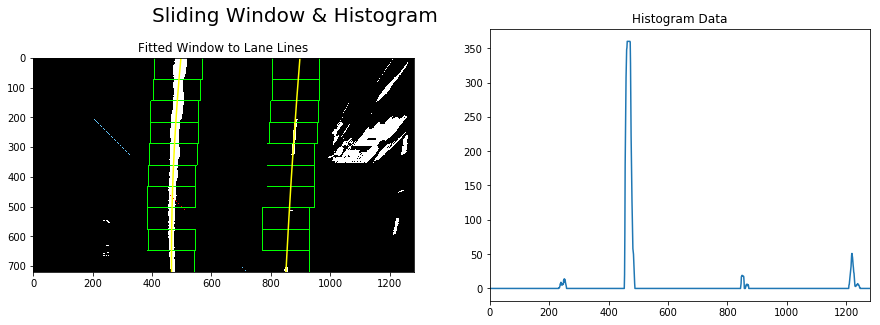

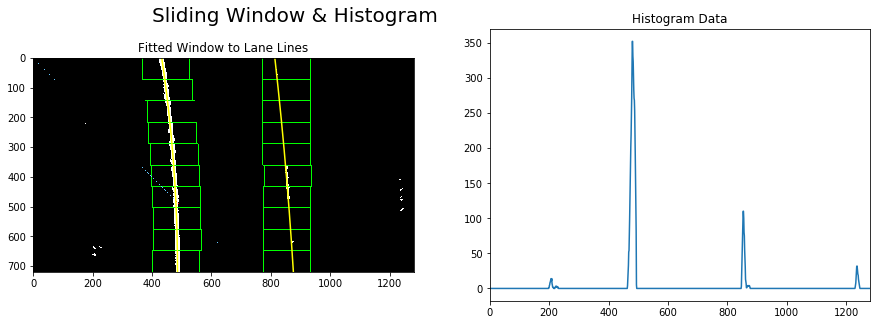

In [26]:
image1 = cv2.cvtColor( cv2.imread( './test_images/test1.jpg' ), cv2.COLOR_BGR2RGB )
image_piped_1, Minv = pipeline( image1, mtx, dist, 'no' )

image2 = cv2.cvtColor( cv2.imread( './test_images/test2.jpg' ), cv2.COLOR_BGR2RGB )
image_piped_2, Minv = pipeline( image2, mtx, dist, 'no' )
    
l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist = fit_sliding_window( image_piped_1 )
    
plot_sliding_window( image_piped_1, l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist )

l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist = fit_sliding_window( image_piped_2 )
    
plot_sliding_window( image_piped_2, l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist )

### Detect lane pixels and fit to find the lane boundary.

The below functions detect and plot sliding windows over estimations of where the lane markers are detected, this time using the posterior estimation as a first guess.

In [27]:
### Fit and plot sliding fitted windows using posterior estimation

# Method to fit polynomial to image based upon a previous fit assumuing fit will not change 
# significantly from one frame to the next
def fit_window_with_posterior( binary_warped, old_fit_l, old_fit_r ):
    
    # Identify x, y positions of all nonzero pixels in the image and margin
    nzero = binary_warped.nonzero()
    nzero_y, nzero_x, margin = np.array( nzero[0] ), np.array( nzero[1] ), 80

    # Lane indices comment
    lane_inds_l = ( ( nzero_x > \
                ( old_fit_l[0] * ( nzero_y ** 2 ) + old_fit_l[1] * nzero_y + old_fit_l[2] - margin ) ) \
                & \
                ( nzero_x < \
                ( old_fit_l[0] * ( nzero_y ** 2 ) + old_fit_l[1] * nzero_y + old_fit_l[2] + margin ) ) )
    
    lane_inds_r = ( ( nzero_x > \
                ( old_fit_r[0] * ( nzero_y ** 2 ) + old_fit_r[1] * nzero_y + old_fit_r[2] - margin ) ) \
                & \
                ( nzero_x < \
                ( old_fit_r[0] * ( nzero_y ** 2 ) + old_fit_r[1] * nzero_y + old_fit_r[2] + margin ) ) )  

    # Extract left, right line pixel positions
    pix_x_l = nzero_x[ lane_inds_l ]
    pix_x_r = nzero_x[ lane_inds_r ]
    pix_y_l = nzero_y[ lane_inds_l ] 
    pix_y_r = nzero_y[ lane_inds_r ]
    
    # Fit a second order polynomial to each position
    new_fit_l, new_fit_r = None, None
    
    if len( pix_x_l ) != 0:
        new_fit_l = np.polyfit( pix_y_l, pix_x_l, 2 )
    
    if len( pix_x_r ) != 0:
        new_fit_r = np.polyfit( pix_y_r, pix_x_r, 2 )
    
    return new_fit_l, new_fit_r, lane_inds_l, lane_inds_r


def plot_window_with_posterior( img_bin, l_fit, r_fit, l_fit_new, r_fit_new, lanes_new_l, lanes_new_r ):

    # Create image to draw on and image to show the selection
    img_out = np.uint8( np.dstack( ( img_bin, img_bin, img_bin ) ) * 255 )
    img_win = np.zeros_like( img_out )

    # Generate x, y values for plotting
    plotyy = np.linspace( 0, img_bin.shape[0] - 1, img_bin.shape[0] )
    l_fit_x_old = l_fit[0] * plotyy ** 2 + l_fit[1] * plotyy + l_fit[2]
    r_fit_x_old = r_fit[0] * plotyy ** 2 + r_fit[1] * plotyy + r_fit[2]
    l_fit_x_new = l_fit_new[0] * plotyy ** 2 + l_fit_new[1] * plotyy + l_fit_new[2]
    r_fit_x_new = r_fit_new[0] * plotyy ** 2 + r_fit_new[1] * plotyy + r_fit_new[2]

    # Identify x, y positions of all nonzero pixels in the image and margin
    nzero = img_bin.nonzero( )
    nzero_y, nzero_x, margin = np.array( nzero[0] ), np.array( nzero[1] ), 80

    img_out[ nzero_y[ lanes_new_l ], nzero_x[ lanes_new_l ] ] = [ 255, 0, 0 ]
    img_out[ nzero_y[ lanes_new_r ], nzero_x[ lanes_new_r ] ] = [ 0, 0, 255 ]

    # Generate a polygon to illustrate the search window area, recast 
    window_l_1 = np.array( [ np.transpose( np.vstack( [ l_fit_x_old - margin, plotyy ] ) ) ] )
    window_l_2 = np.array( [ np.flipud( np.transpose( np.vstack( [ l_fit_x_old + margin, plotyy ] ) ) ) ] )

    l_line_pts = np.hstack( ( window_l_1, window_l_2 ) )

    window_r_1 = np.array( [ np.transpose( np.vstack( [ r_fit_x_old - margin, plotyy ] ) ) ] )
    window_r_2 = np.array( [ np.flipud( np.transpose( np.vstack( [ r_fit_x_old + margin, plotyy ] ) ) ) ] )

    r_line_pts = np.hstack( ( window_r_1, window_r_2 ) )

    # Draw the lane onto the warped blank image
    cv2.fillPoly( img_win, np.int_( [ l_line_pts ] ), ( 0, 255, 0 ) )
    cv2.fillPoly( img_win, np.int_( [ r_line_pts ] ), ( 0, 255, 0 ) )
    output = cv2.addWeighted( img_out, 1, img_win, 0.3, 0 )
    plt.figure( figsize=( 9, 6 ) )
    plt.imshow( output )
    plt.plot( l_fit_x_new, plotyy, color='yellow' )
    plt.plot( r_fit_x_new, plotyy, color='yellow' )
    plt.xlim( 0, 1280 )
    plt.ylim( 720, 0 )
    
    plt.savefig( "./output_images/posterior_img.jpg" )
    
    return None

###

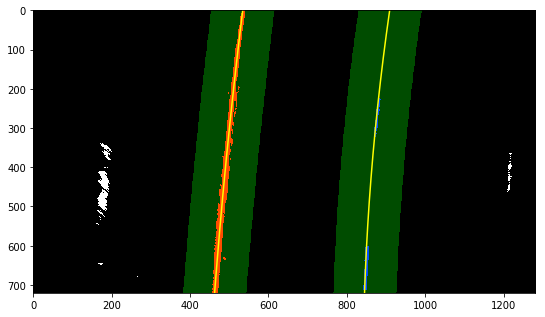

In [28]:
# visualize the result on example image
image3 = cv2.cvtColor( cv2.imread( './test_images/test3.jpg' ), cv2.COLOR_BGR2RGB )
image_piped_3, Minv = pipeline( image3, mtx, dist, 'no' )   

l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist = fit_sliding_window( image_piped_3 )

l_fit_new, r_fit_new, lanes_new_l, lanes_new_r = fit_window_with_posterior( image_piped_3, l_fit, r_fit )

plot_window_with_posterior( image_piped_3, l_fit, r_fit, l_fit_new, r_fit_new, lanes_new_l, lanes_new_r )


### Determine the curvature of the lane and vehicle position with respect to center.
### Warp the detected lane boundaries back onto the original image.
### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [29]:
### Radius of curvature and lane area plotted

# Determine radius of curvature and distance from lane center from image, polynomial fit, and lane pix indices
def get_radius_of_curvature( img, l_fit, r_fit, lane_inds_l, lane_inds_r ):
    
    # Define x, y conversions from pixel space to meters
    # m/pix in y dim: lane is 10 ft = 3.048 meters, m/pix in x dim, lane is 12 ft = 3.7 meters
    m_per_pix_y, m_per_pix_x = ( 3.048 / 100 ), ( 3.7 / 378 )
    
    # Initialise output vars
    radius_l, radius_r, center_distance = 0, 0, 0
    
    # Define y-value from where to measure radius of curvature, or the bottom of the image
    win_h = img.shape[0]
    max_y = np.max( np.linspace( 0, ( win_h - 1 ), win_h ) )

    # Identify x, y positions of all nonzero pixels in the image
    nzero = img.nonzero( )
    nzero_y, nzero_x = np.array( nzero[0] ), np.array( nzero[1] )
    
    # Extract left, right line pixel positions
    pix_x_l = nzero_x[ lane_inds_l ]
    pix_x_r = nzero_x[ lane_inds_r ]
    pix_y_l = nzero_y[ lane_inds_l ] 
    pix_y_r = nzero_y[ lane_inds_r ]
    
    if len( pix_x_l ) != 0 and len( pix_x_r ) != 0:
        
        # Fit new polynomials to x, y in world space in meters
        new_fit_l = np.polyfit( pix_y_l * m_per_pix_y, pix_x_l * m_per_pix_x, 2 )
        new_fit_r = np.polyfit( pix_y_r * m_per_pix_y, pix_x_r * m_per_pix_x, 2 )
        
        # Calculate the new radii of curvature, in meters
        radius_l = ( ( 1 + ( 2 * new_fit_l[0] * max_y * m_per_pix_y + new_fit_l[1] ) ** 2 ) ** 1.5 ) \
                / np.absolute( 2 * new_fit_l[0] )
        radius_r = ( ( 1 + ( 2 * new_fit_r[0] * max_y * m_per_pix_y + new_fit_r[1] ) ** 2 ) ** 1.5 ) \
                / np.absolute( 2 * new_fit_r[0] )
    
    # Centerline distance is mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        
        l_fit_intercept = l_fit[0] * win_h ** 2 + l_fit[1] * win_h + l_fit[2]
        r_fit_intercept = r_fit[0] * win_h ** 2 + r_fit[1] * win_h + r_fit[2]              
        
        lane_center_position = ( r_fit_intercept + l_fit_intercept ) / 2
        car_position = img.shape[1] / 2
        
        center_distance = ( car_position - lane_center_position ) * m_per_pix_x
    
    return radius_l, radius_r, center_distance


# Method to draw lane area over undistorted image 
def draw_lane_data( original_img, binary_img, l_fit, r_fit, Minv, rad_l, rad_r, center_dist ):
    
    new_img = np.copy( original_img )
    
    # get out if fitted lines are no good
    if l_fit is None or r_fit is None:
        return original_img
    
    # Create image to draw on and image to show the selection
    zeros = np.zeros_like( binary_img ).astype( np.uint8 )
    warped_color = np.dstack( ( zeros, zeros, zeros ) )
    
    # Set window parameters 
    win_h, win_w = binary_img.shape
    
    # Generate x, y values for plotting
    plotyy = np.linspace( 0, ( win_h - 1 ), win_h ) #num=win_h
    l_fit_x = l_fit[0] * plotyy ** 2 + l_fit[1] * plotyy + l_fit[2]
    r_fit_x = r_fit[0] * plotyy ** 2 + r_fit[1] * plotyy + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly( )
    points_l = np.array( [ np.transpose( np.vstack( [ l_fit_x, plotyy ] ) ) ] )
    points_r = np.array( [ np.flipud( np.transpose( np.vstack( [ r_fit_x, plotyy ] ) ) ) ] )
    points = np.hstack( ( points_l, points_r ) )

    # Draw the lane onto the warped, blank image
    cv2.fillPoly( warped_color, np.int_( [points] ), ( 25, 255, 125 ) )
    cv2.polylines( warped_color, np.int32( [points_l] ), isClosed=False, color=( 255, 0, 255 ), thickness=12 )
    cv2.polylines( warped_color, np.int32( [points_r] ), isClosed=False, color=( 255, 0, 255 ), thickness=12 )

    # Warp the blank back to original image space using inverse perspective matrix, Minv
    lane_area = cv2.warpPerspective( warped_color, Minv, ( win_w, win_h ) ) 
    
    # Combine the result with the original image
    lane_area_filled = cv2.addWeighted( new_img, 1, lane_area, 0.5, 0 )
    
    # Add radius, center text to image
    if center_dist >= 0:
        orientation = 'right'
    elif center_dist < 0:
        orientation = 'left'
    else:
        orientation = 'NULL'
    font = cv2.FONT_HERSHEY_PLAIN
    txt1 = 'Radius of Curvature: ' + '{:04.2f}'.format( (rad_l + rad_r ) / 2 ) + 'm'
    txt2 = '{:04.3f}'.format( abs( center_dist ) ) + 'm ' + orientation + ' of center'
    cv2.putText( lane_area_filled, txt1, ( 40,  70 ), font, 2.0, ( 100, 255, 125 ), 2, cv2.LINE_AA )
    cv2.putText( lane_area_filled, txt2, ( 40, 100 ), font, 2.0, ( 100, 255, 125 ), 2, cv2.LINE_AA )
    
    plt.savefig( "./output_images/filled_lane_img.jpg" )
    
    return lane_area_filled

###

Radius of curvature: 1473.5942785402497 m, 622.8931579933735 m
Distance from lane center: -0.13487508765120165 m


<Figure size 432x288 with 0 Axes>

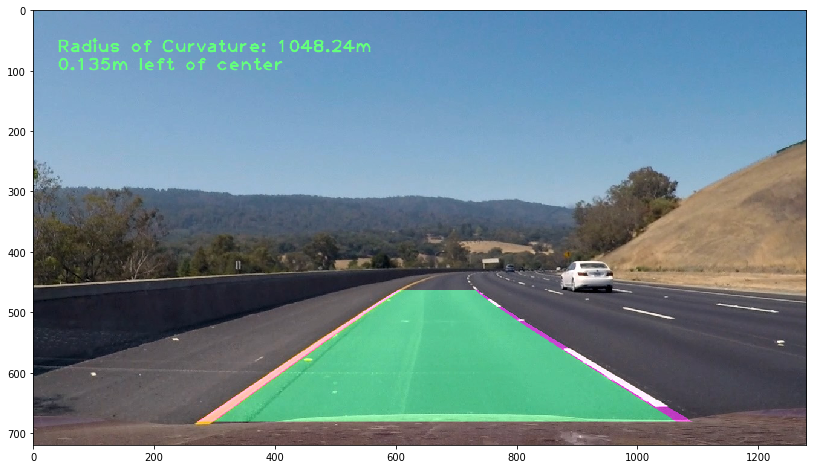

In [30]:
###
rad_l, rad_r, dist_center = get_radius_of_curvature( image_piped_3, l_fit, r_fit, lane_inds_l, lane_inds_r )

print( 'Radius of curvature:', rad_l, 'm,', rad_r, 'm' )
print( 'Distance from lane center:', dist_center, 'm' )

lane_area_3 = draw_lane_data( image3, image_piped_3, l_fit, r_fit, Minv, rad_l, rad_r, dist_center )

plt.figure( figsize=( 14, 8 ) )
plt.imshow( lane_area_3 )
plt.show( )
###

In [31]:
###
def process_image( original_img, mtx, dist, l_line, r_line, plot='yes' ):
    
    new_img = np.copy( original_img )
    piped_img, Minv = pipeline( new_img, mtx, dist, 'no' )
    
    # if both left and right lines were detected last frame, use posterior estimate
    if not l_line.detected or not r_line.detected:
        #print("Initial!!")
        l_fit, r_fit, lane_inds_l, lane_inds_r, rect, hist = fit_sliding_window( piped_img )
    else:
        #print("Posterior!")
        l_fit, r_fit, lane_inds_l, lane_inds_r = fit_window_with_posterior( \
                                                    piped_img, l_line.best_fit, r_line.best_fit )

    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        
        # calculate x-intercept for fits, (bottom of image, image_height)
        win_h = original_img.shape[0]
        l_fit_intercept = l_fit[0] * win_h ** 2 + l_fit[1] * win_h + l_fit[2]
        r_fit_intercept = r_fit[0] * win_h ** 2 + r_fit[1] * win_h + r_fit[2]  

        # if difference is too large, throw out fit and start again
        if abs( 350 - abs( r_fit_intercept - l_fit_intercept ) ) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fitted_line( l_fit, lane_inds_l )
    r_line.add_fitted_line( r_fit, lane_inds_r )

    # draw the current best fit if it exists
    if ( l_line.best_fit is not None ) and ( r_line.best_fit is not None ):
        
        rad_l, rad_r, d_center = get_radius_of_curvature( \
                                 piped_img, l_line.best_fit, r_line.best_fit, lane_inds_l, lane_inds_r )
        
        out_img = draw_lane_data( \
                     new_img, piped_img, l_line.best_fit, r_line.best_fit, Minv, rad_l, rad_r, d_center )
        
    else:
        
        out_img = new_img

    if plot == 'yes' or plot == 'YES':

        plt.figure( figsize=( 9, 6 ) )
        plt.imshow( out_img )
        
        plt.savefig( "./output_images/processed_img.jpg" )
        
    return out_img


def process_video( image ):
    
    # return processed image for use in VideoFileClip.fl_image( )
    return process_image( image, mtx, dist, line_l, line_r, 'no' )

###

<Figure size 432x288 with 0 Axes>

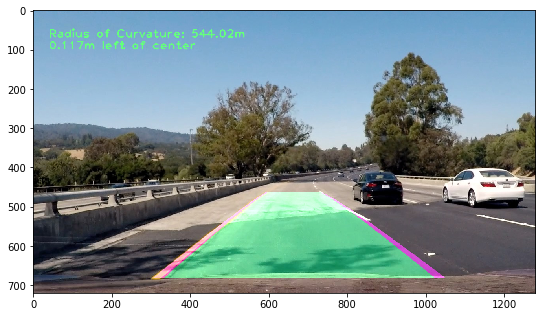

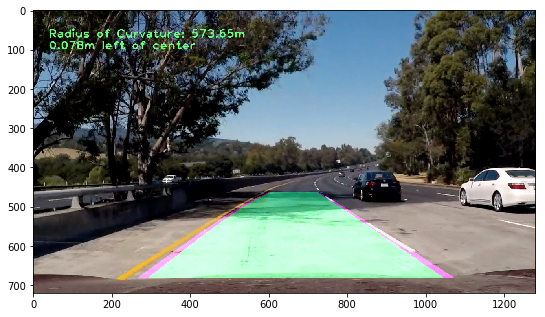

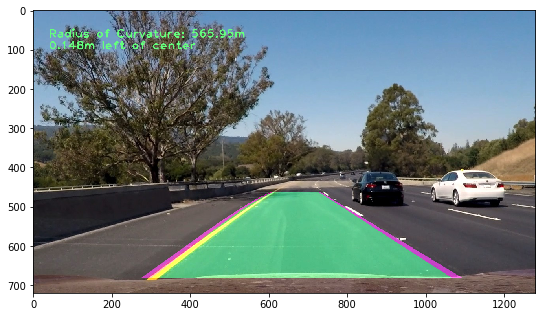

In [32]:
### Visualize pipeline on read images, prep for videos

line_l, line_r = Line.Line( ), Line.Line( )

image4 = cv2.cvtColor( cv2.imread( './test_images/test4.jpg' ), cv2.COLOR_BGR2RGB )
image_piped_4, Minv = pipeline( image4, mtx, dist, 'no' )

processed4 = process_image( image4, mtx, dist, line_l, line_r, 'yes' )

image5 = cv2.cvtColor( cv2.imread( './test_images/test5.jpg' ), cv2.COLOR_BGR2RGB )
image_piped_5, Minv = pipeline( image5, mtx, dist, 'no' )

processed5 = process_image( image5, mtx, dist, line_l, line_r, 'yes' )

image6 = cv2.cvtColor( cv2.imread( './test_images/test6.jpg' ), cv2.COLOR_BGR2RGB)
image_piped_6, Minv = pipeline( image6, mtx, dist, 'no' )  

processed6 = process_image( image6, mtx, dist, line_l, line_r, 'yes' )

###

In [14]:
### Process videos through pipeline

line_l, line_r = Line.Line( ), Line.Line( )

video_input_names = [ \
        './videos/project_video.mp4', \
        './videos/challenge_video.mp4', \
        './videos/harder_challenge_video.mp4' \
        ]

video_output_names = [ \
        './project_video_output.mp4', \
        'challenge_video_output.mp4', \
        'harder_challenge_video_output.mp4' \
        ]

for v in range( len( video_input_names ) ):

    video_input = VideoFileClip( video_input_names[v], audio=False )

    processed_video = video_input.fl_image( process_video )

    %time processed_video.write_videofile( video_output_names[v], audio=False )

###

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [02:04<00:00, 10.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 5min, sys: 1.23 s, total: 5min 1s
Wall time: 2min 5s
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:56<00:00,  8.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 4s, sys: 1.15 s, total: 2min 5s
Wall time: 57.6 s
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:30<00:00,  7.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 5min 27s, sys: 1.66 s, total: 5min 29s
Wall time: 2min 31s
